# Titanic Survivor Predictions

We need to determine whether or not each passenger survives. To do this we can look at the factors which may or may not affect their survival rate. These include their gender, age, socio-economic class (which we may infer from their ticket class) and other factors included in the data. We first import the necessary packages:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

We then read both the training and testing csv datasets:

In [2]:
training = pd.read_csv('./train.csv')
testing = pd.read_csv('./test.csv')

In [3]:
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We will check for any missing values, or NaN or null values in the training data:

In [4]:
training.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It appears we have 177 null values in the Age column, 687 null values in the Cabin column, and 2 null values in the Embarked column. The Cabin column may not cause us too much difficulty. However, the null values in the age column may cause issues. We will leave them as is for now. The total number of adults and children on board compared to the numbers of adult and child survivors can e visualised:

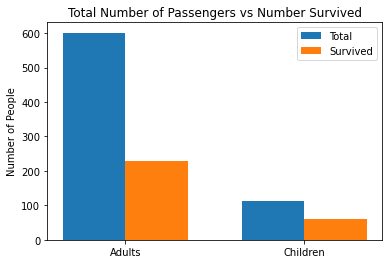

In [5]:
num_children = len(training.loc[training.Age < 18])
num_adults = len(training.loc[training.Age >= 18])
child_survivors = training.loc[training.Age < 18].Survived.sum()
adult_survivors = training.loc[training.Age >= 18].Survived.sum()

labels = ['Adults', 'Children']
total_nums = [num_adults, num_children]
survived_nums = [adult_survivors, child_survivors]

x = np.arange(len(labels))
width = 0.35

fig, ax_totals = plt.subplots()
ax_totals.bar(x - width/2, total_nums, width, label='Total')
ax_totals.bar(x + width/2, survived_nums, width, label='Survived')

ax_totals.set_ylabel('Number of People')
ax_totals.set_title('Total Number of Passengers vs Number Survived')
ax_totals.set_xticks(x)
ax_totals.set_xticklabels(labels)
ax_totals.legend()

plt.show()

Of those surviving children and adults we can look at the breakdown of how many were male/female:

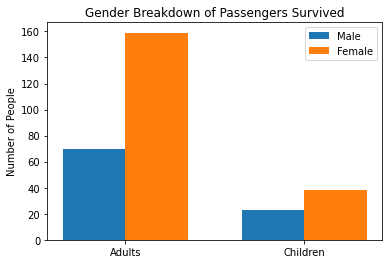

In [6]:
male_child_survivors = training.loc[(training.Age < 18) & (training.Sex == 'male')].Survived.sum()
female_child_survivors = training.loc[(training.Age < 18) & (training.Sex == 'female')].Survived.sum()
male_adult_survivors = training.loc[(training.Age >= 18) & (training.Sex == 'male')].Survived.sum()
female_adult_survivors = training.loc[(training.Age >= 18) & (training.Sex == 'female')].Survived.sum()

labels = ['Adults', 'Children']
male_survivors = [male_adult_survivors, male_child_survivors]
female_survivors = [female_adult_survivors, female_child_survivors]

x = np.arange(len(labels))
width = 0.35

fig_survivors, ax_survivors = plt.subplots()
ax_survivors.bar(x - width/2, male_survivors, width, label='Male')
ax_survivors.bar(x + width/2, female_survivors, width, label='Female')

ax_survivors.set_ylabel('Number of People')
ax_survivors.set_title('Gender Breakdown of Passengers Survived')
ax_survivors.set_xticks(x)
ax_survivors.set_xticklabels(labels)
ax_survivors.legend()

plt.show()

So it is evident that females are in the majority of those survived. Particularly, more than twice as many adult females survived than adult males. We can now look to the socio-economic factor. So first determining what class of passenger is more likely to survive:

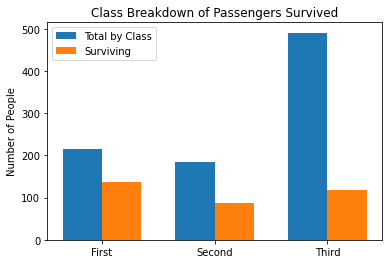

In [7]:
num_first = len(training[training.Pclass == 1])
num_second = len(training[training.Pclass == 2])
num_third = len(training[training.Pclass == 3])
first_survivors = training[training.Pclass == 1].Survived.sum()
second_survivors = training[training.Pclass == 2].Survived.sum()
third_survivors = training[training.Pclass == 3].Survived.sum()

labels = ['First', 'Second', 'Third']
totals_class = [num_first, num_second, num_third]
survivors_class = [first_survivors, second_survivors, third_survivors]

x = np.arange(len(labels))
width = 0.35

fig_class, ax_class = plt.subplots()
ax_class.bar(x - width/2, totals_class, width, label='Total by Class')
ax_class.bar(x + width/2, survivors_class, width, label='Surviving')

ax_class.set_ylabel('Number of People')
ax_class.set_title('Class Breakdown of Passengers Survived')
ax_class.set_xticks(x)
ax_class.set_xticklabels(labels)
ax_class.legend()

plt.show()

It is clear that a higher percentage of higher class people survived. While "similar" numbers of passengers across the three classes survived (i.e. 136 vs 87 vs 119) the percentage surviving is stark (63% vs 47% vs 24%).

As a first step to making predictions on who would survive we start with a K-Nearest Neighbours algorithm. We first must clean the data and also split the training data into a training and validation set:

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
training.Age.fillna(training.Age.mean(), inplace=True)
training.replace({"male": 1, "female": 0}, inplace = True)

reduced_features = training[['Pclass', 'Sex', 'Age', 'SibSp']]
targets = training['Survived']

X_train, X_validation, y_train, y_validation = train_test_split(reduced_features, targets, train_size=0.7, test_size=0.3)

We then can implement the KNN model and obtain a measure of the accuracy of predicting survivors using the accuracy score and F1 score:

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score

In [11]:
knn_model = KNeighborsClassifier(5)
knn_model.fit(X_train, y_train)
predicted_knn_survival = knn_model.predict(X_validation)
knn_f1_score = f1_score(predicted_knn_survival, y_validation)
knn_accuracy_score = accuracy_score(predicted_knn_survival, y_validation)

print('F1 score:', knn_f1_score)
print('Accuracy score:', knn_accuracy_score)

F1 score: 0.6387434554973822
Accuracy score: 0.7425373134328358


As a second step we will implement a Support Vector Machine:

In [12]:
from sklearn.svm import SVC

In [13]:
svc_model = SVC(kernel = 'linear', C = 1)
svc_model.fit(X_train, y_train)
predicted_svc_survival = svc_model.predict(X_validation)
svc_f1_score = f1_score(predicted_svc_survival, y_validation)
svc_accuracy_score = accuracy_score(predicted_svc_survival, y_validation)

print('F1 score:', svc_f1_score)
print('Accuracy score:', svc_accuracy_score)

F1 score: 0.693069306930693
Accuracy score: 0.7686567164179104


As a final step we will implement a simple decision tree:

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
decision_model = DecisionTreeClassifier(max_depth = 4)
decision_model.fit(X_train, y_train)
predicted_decision_survival = decision_model.predict(X_validation)
decision_f1_score = f1_score(predicted_decision_survival, y_validation)
decision_accuracy_score = accuracy_score(predicted_decision_survival, y_validation)

print('F1 score:', decision_f1_score)
print('Accuracy score:', decision_accuracy_score)

F1 score: 0.7487179487179487
Accuracy score: 0.8171641791044776
